# Introduction
This notebook calculates pValues for the independant variables via bootstrapping.  Note that we are just looking for p-values. So train the rf on the entire dataset with 1 column scrambled, then get MEMs .  Do this many times.  Then train the entire rf with that column unscrambled, then get MEMs.  Plot these MEMs values.
Please be sure to run DataCleaning.ipynb first to prepare the data

This notebook based on Fastai V1 ML course

## Imports
Import libraries and write settings here.

In [61]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# DETERMINE IF YOU ARE USING RAW OR SCALED
Scaled is Zhao's data, continuous variables divided by standard deviation
<br>Raw is unscaled raw data

In [39]:
useRaw=False

outdir = 'pvals'
filename='pvalsMEMs'
os.makedirs(outdir, exist_ok=True)

# the dependant variable(s)
columns_dep_var= ['cc.TrumpGEVote','cc.TrumpPVote', 'cc.vote12.gop']

#get the data
if (useRaw == True):
    df = pd.read_csv('./data/ccesplus.csv',encoding = "ISO-8859-1")
else:
    df = pd.read_csv('./data/ccesplus_fscaled.csv',encoding = "ISO-8859-1")

# Choose which dependant variable to operate on

In [40]:
dep_var = columns_dep_var[2]
dump_these_dep_var_columns=columns_dep_var.copy()
dump_these_dep_var_columns.remove(dep_var)
dep_var

'cc.vote12.gop'

## Get the columns of interest, including all dependent vars

In [41]:
all = pd.read_excel('./data/CCESplusVariables.xlsx',encoding = "ISO-8859-1")

# for every regid=3.1 get the third column (variable name) convert to a list
columns = list(all[ (all['regid']==1.1) & (all['exclude']!='t')  ].iloc[:,2])

# #strip dependant variables
# columns = [col for col in columns if col not in columns_dep_var]
# columns

In [42]:
#WARNING! 'cc.i.white.educhs not in df! No worries though 
#its correlated with composed of cc.maxeduc.hs and cc.WhiteDum
#so drop it
columns.remove('cc.i.white.educhs')

In [43]:
len(columns)
# columns

35

## Extract just those columns from orig dataframe

In [44]:
df = df[columns]

In [45]:
len(df.columns)

35

## Remove NaN dependent variable rows


In [46]:
def remove_dep_var_nan_rows(df, col_dep_var, dump_these_dep_var_columns ,silent = False):
    """
    parse df into rows where df.col_dep_var does not have NaNs, 
    df: dataframe to pull NaN rows out of
    col_dep_var: dependent variable
    dump_these_dep_var_columns: other dep_var columns that may be highly correlated with dep var
    """
    dftmp= df.copy()
    
    if(silent is False):
        print(f'dropping {(pd.isnull(dftmp[col_dep_var])).sum()} rows where {col_dep_var}=NaN')
                      
    #dump the NaN rows
    dftmp = dftmp[pd.notnull(dftmp[col_dep_var] )]
    
    #dump the dump_these_dep_var_columns
    dftmp.drop(dump_these_dep_var_columns,axis=1,inplace=True);
    
    return dftmp

# pull out the nulls from the column of interest
dftmp= remove_dep_var_nan_rows(df, columns_dep_var[0],dump_these_dep_var_columns )

dropping 23710 rows where cc.TrumpGEVote=NaN


In [47]:
#get a list of the columns to operate on minus the dependant variable
columns = dftmp.columns.drop(dep_var)
columns

Index(['cc.emp.nojob', 'cc.CC16_304', 'cc.faminc', 'crashpc', 'rustpc',
       'job.uer', 'econ.mhi', 'econ.hhpov.p', 'taa.wrks.disc95.pcpy',
       'cc.CC16_305_2', 'mort.ucd.despair.disc95.pdpy', 'cc.immviewsum',
       'cc.raceviewsum', 'cc.CC16_307', 'cc.CC16_351B', 'cc.Age', 'cc.Sex',
       'cc.BlackDum', 'cc.WhiteDum', 'cc.maxeduc.4yr', 'cc.maxeduc.hs',
       'cc.isimmigrant', 'cc.child18', 'cc.union', 'cc.newsint', 'cc.Ideo7',
       'cc.EvanProt', 'cc.Catholic', 'cc.Religiosity', 'demo.popdense',
       'cc.RepDum', 'cc.IndDum'],
      dtype='object')

## Split out categorical and continuous variables
see if fastai can auto do it

In [48]:
# #give fastai a shot at splitting cat and cont variables
res_cont, res_cat = cont_cat_split(dftmp,max_card=18)

## Categorify and Fill Missing

In [49]:
#from docs https://docs.fast.ai/tabular.transform.html
# tfm = Categorify(cat_names=res_cat, cont_names=res_cont)
# tfm(dftmp)

In [50]:
tfm1 = FillMissing(cat_names=res_cat, cont_names=res_cont, add_col=False)
tfm1(dftmp)

In [51]:
len(dftmp.columns)

33

## Split out dependant variable 

In [52]:
trn=dftmp
len(trn)

40890

In [53]:
#split out trn_y 
#this is the dep_var, converted to an int
trn_y = trn[dep_var].copy()
trn_y.astype('int64');

trn.drop(dep_var,axis=1,inplace=True);

## Generate MEM row 
RUN ON WHOLE DATASET OR JUST THE TestSET?  I'm thinking the whole dataset.  
The model has some idea of how voters will vote based on the input features, lets use that knowledge
to see what happens when we start changing variables

In [55]:
all = trn.copy()
all_y = trn_y.copy()
len(all)
all.head()

40890

,cc.emp.nojob,cc.CC16_304,cc.faminc,crashpc,rustpc,job.uer,econ.mhi,econ.hhpov.p,taa.wrks.disc95.pcpy,cc.CC16_305_2,mort.ucd.despair.disc95.pdpy,cc.immviewsum,cc.raceviewsum,cc.CC16_307,cc.CC16_351B,cc.Age,cc.Sex,cc.BlackDum,cc.WhiteDum,cc.maxeduc.4yr,cc.maxeduc.hs,cc.isimmigrant,cc.child18,cc.union,cc.newsint,cc.Ideo7,cc.EvanProt,cc.Catholic,cc.Religiosity,demo.popdense,cc.RepDum,cc.IndDum
1,0,0.947973,0.843277,0.785922,0.54909,0.935341,0.921328,0.906772,0.400526,0,0.943574,0.850569,0.74893,1.183436,1.0,1.261005,1,0,1,1,0,0,0.0,1.0,0.431581,1.578771,1.0,0.0,1.448094,0.067186,1.0,0.0
4,0,0.315991,1.124369,0.785922,0.54909,0.935341,0.921328,0.906772,0.400526,0,0.943574,0.000000,0.42796,1.183436,0.0,1.477740,0,0,1,1,0,0,0.0,0.0,0.431581,0.225539,0.0,0.0,0.995565,0.067186,0.0,0.0
7,0,1.263963,0.843277,0.785922,0.54909,0.935341,0.921328,0.906772,0.400526,0,0.943574,1.275854,1.06990,1.183436,1.0,1.595959,1,0,1,1,0,0,0.0,1.0,0.431581,1.353232,0.0,0.0,1.448094,0.067186,0.0,1.0
9,0,0.947973,1.405461,0.785922,0.54909,0.935341,0.921328,0.906772,0.400526,0,0.943574,0.000000,0.74893,0.887577,0.0,0.768425,0,0,1,0,0,0,1.0,0.0,0.431581,0.902155,0.0,0.0,0.633541,0.067186,0.0,1.0
11,0,0.947973,1.124369,0.785922,0.54909,0.935341,0.921328,0.906772,0.400526,0,0.943574,1.275854,0.85592,0.887577,0.0,1.300411,1,0,1,0,0,0,0.0,0.0,0.431581,0.902155,0.0,0.0,1.357588,0.067186,0.0,1.0


# Generate pValue predictions

In [171]:
#this directory contains symlink created at command line like this
# ln -s ../Marginal_Effects_at_Means ./Marginal_Effects_at_Means
#it allows this directory to find Marginal_Effects_at_Means, a directory 1 above this one
#this dir contains a file called mem.py which contains MEMs
from p_value_calculation.pvals import pValue,pValInfo


.....

.....

.....

.....


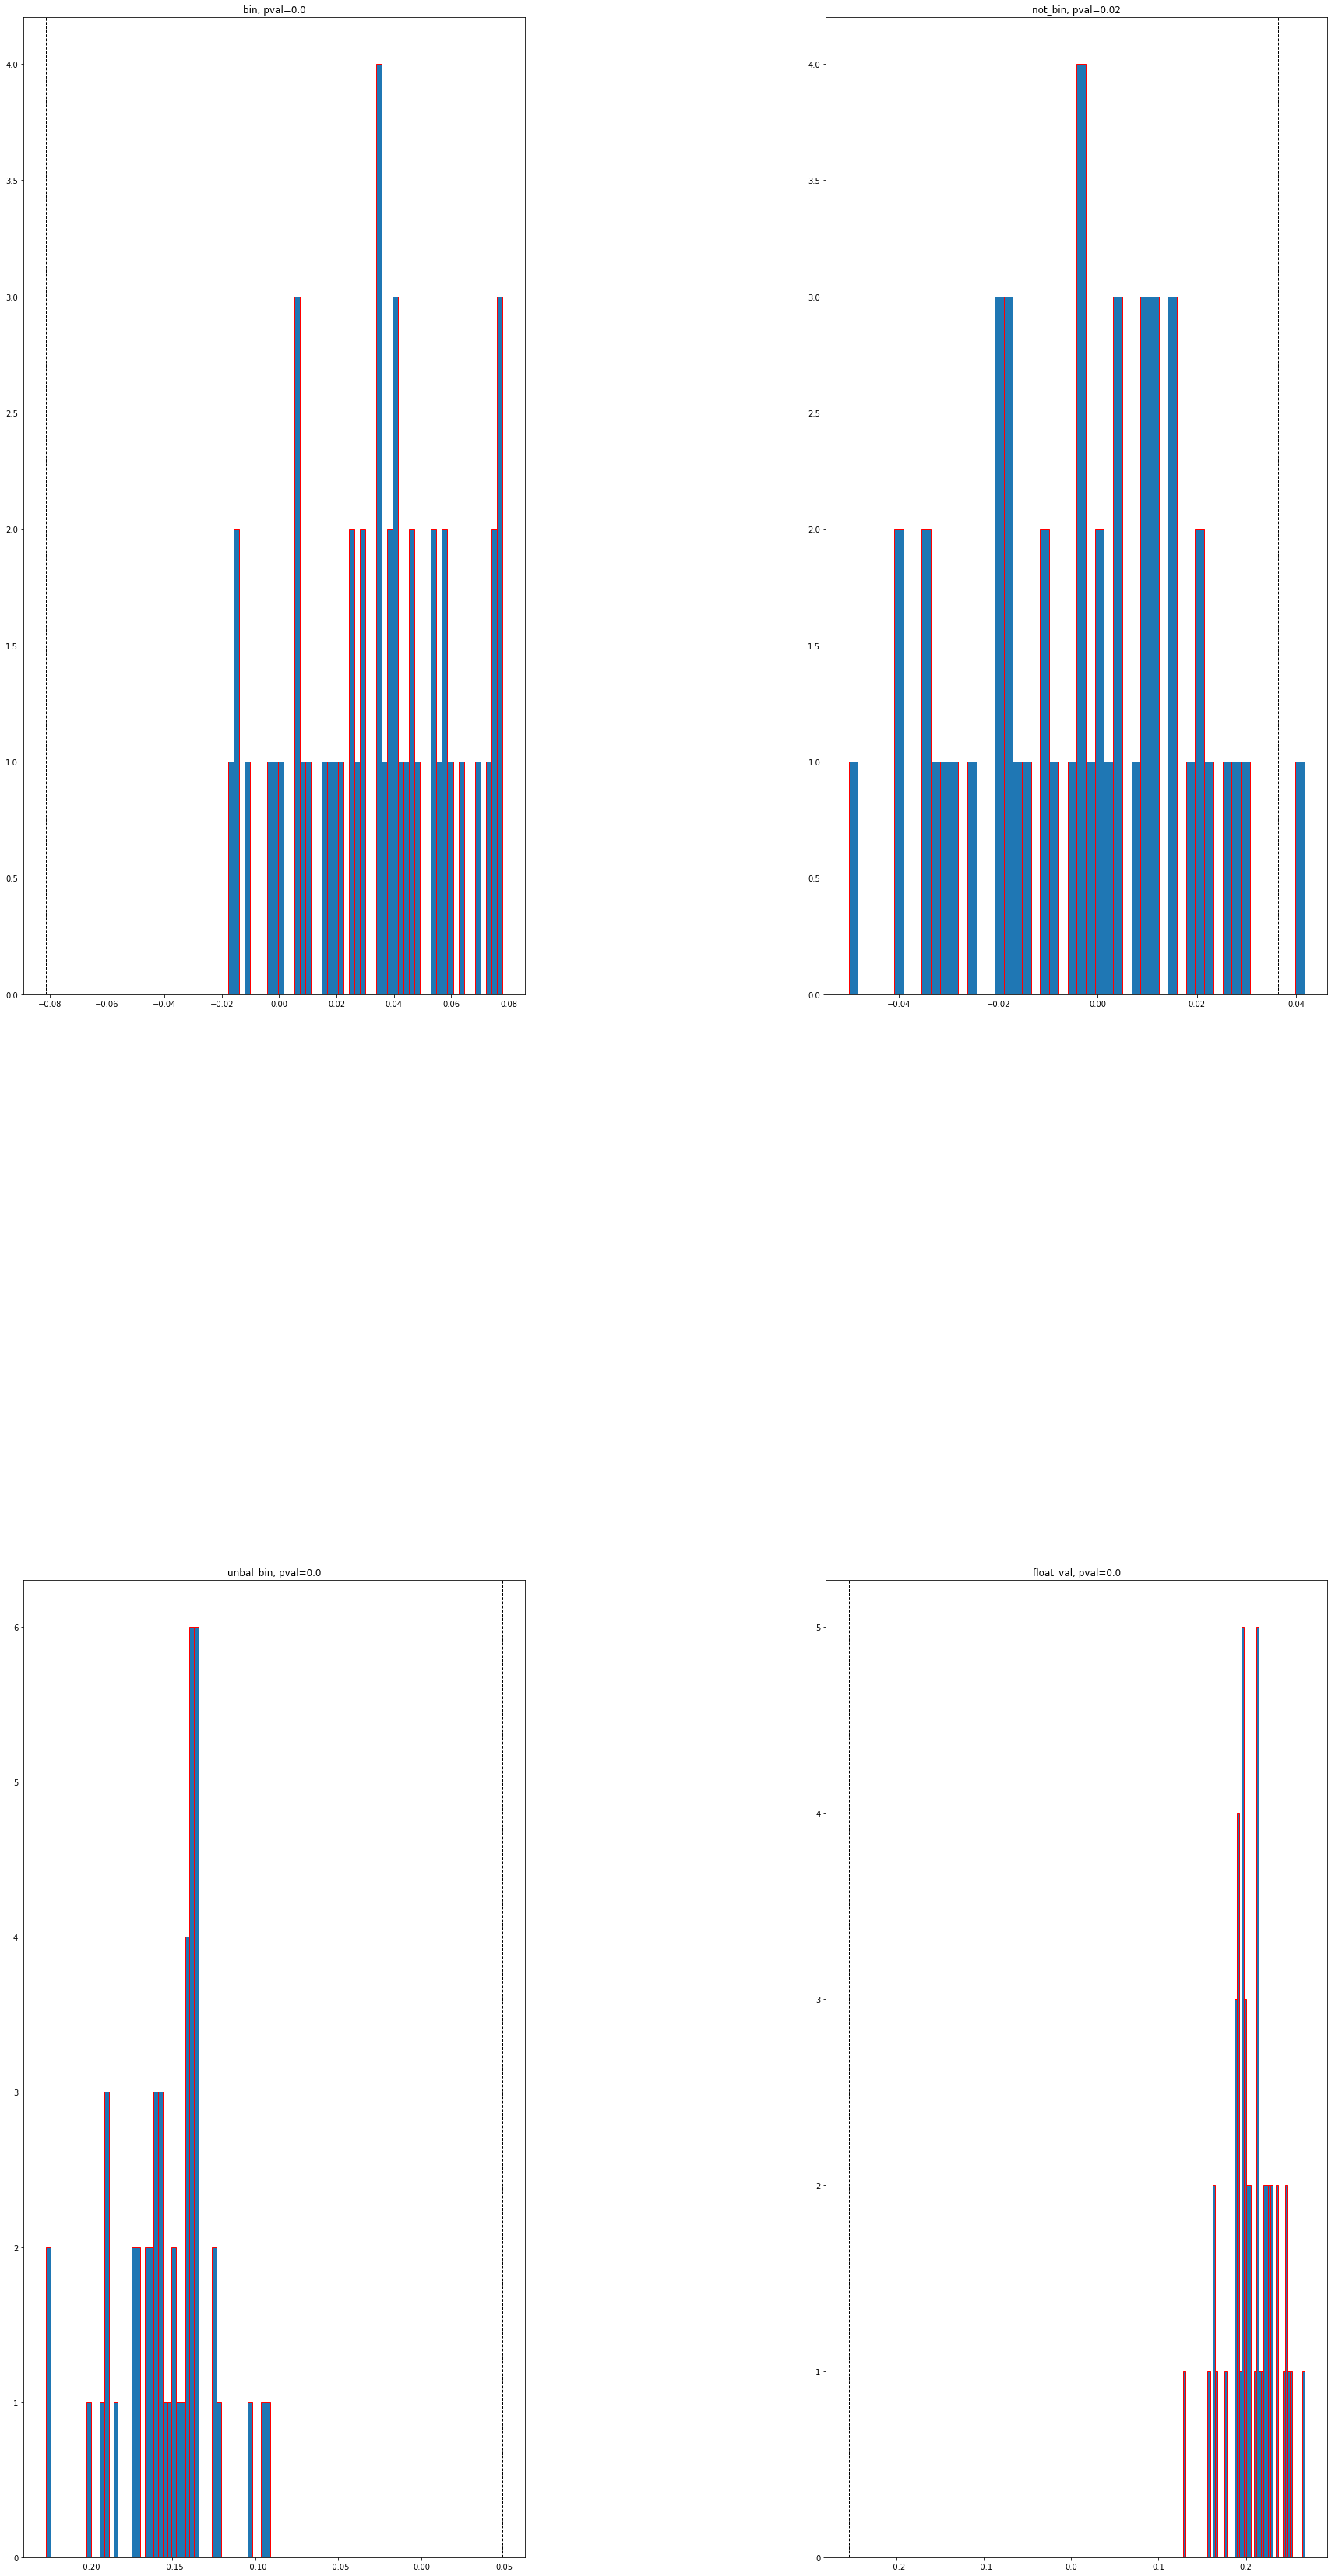

In [74]:
#run the test cases
from p_value_calculation.test_pvals import Test_pvals
tst = Test_pvals()
tst.setUp()
tst.test_get_pval_bin()

In [59]:
# #get something small to train on
# NUMBERSAMPS = 1000
# trn_sm = trn[:NUMBERSAMPS]
# trn_sm_y= trn_y[:NUMBERSAMPS]
# tst_sm = tst[:NUMBERSAMPS]
# tst_sm_y = tst[:NUMBERSAMPS]
# columns=['cc.raceviewsum']

# len(trn_sm),len(trn_sm_y),len(tst_sm) 
# columns = ['cc.raceviewsum', 'cc.CC16_307']

In [121]:
columns
# columns1=['cc.emp.nojob']

Index(['cc.emp.nojob', 'cc.CC16_304', 'cc.faminc', 'crashpc', 'rustpc',
       'job.uer', 'econ.mhi', 'econ.hhpov.p', 'taa.wrks.disc95.pcpy',
       'cc.CC16_305_2', 'mort.ucd.despair.disc95.pdpy', 'cc.immviewsum',
       'cc.raceviewsum', 'cc.CC16_307', 'cc.CC16_351B', 'cc.Age', 'cc.Sex',
       'cc.BlackDum', 'cc.WhiteDum', 'cc.maxeduc.4yr', 'cc.maxeduc.hs',
       'cc.isimmigrant', 'cc.child18', 'cc.union', 'cc.newsint', 'cc.Ideo7',
       'cc.EvanProt', 'cc.Catholic', 'cc.Religiosity', 'demo.popdense',
       'cc.RepDum', 'cc.IndDum'],
      dtype='object')

In [122]:
NUMBERITERATIONS=500
pv=pValue(trn, trn_y,columns,numb_iter=NUMBERITERATIONS, verbose=True)
res = pv.get_all_pvals()

Column cc.emp.nojob

..................................................
Column cc.CC16_304

.........................................
Column cc.faminc

..................................................
Column crashpc

..................................................
Column rustpc

..................................................
Column job.uer

..................................................
Column econ.mhi

..................................................
Column econ.hhpov.p

..................................................
Column taa.wrks.disc95.pcpy

..................................................
Column cc.CC16_305_2

..................................................
Column mort.ucd.despair.disc95.pdpy

..................................................
Column cc.immviewsum

..................................................
Column cc.raceviewsum

..................................................
Column cc.CC16_307

.................................................

# Save, print and plot 

In [181]:
# save this info to disk
pickle.dump(res, open(outdir+"/"+filename+'new', 'wb'))

In [182]:
# load the model from disk
res = pickle.load(open(outdir+"/"+filename+'new', 'rb'))

In [172]:
#used to convert old pValInfo objects to new ones with comparisons (lt, eq) and self.pVal
# res2=[]
# for c in res1:
#     a=pValInfo(c.col)
#     a.correct_pred = c.correct_pred[:]
#     a.permuted_preds = c.permuted_preds[:]
#     res2.append(a)

In [183]:
res=sorted(res)

#print values
for item in res:
    print(f'Column {item.col}, p-value={item.get_pval()}')

Column cc.CC16_304, p-value=0.0
Column cc.immviewsum, p-value=0.0
Column cc.raceviewsum, p-value=0.0
Column cc.CC16_307, p-value=0.0
Column cc.Sex, p-value=0.0
Column cc.Ideo7, p-value=0.0
Column cc.Religiosity, p-value=0.0
Column demo.popdense, p-value=0.0
Column cc.RepDum, p-value=0.0
Column cc.IndDum, p-value=0.0
Column cc.isimmigrant, p-value=0.008
Column cc.union, p-value=0.008000000000000007
Column cc.BlackDum, p-value=0.01200000000000001
Column cc.Age, p-value=0.018
Column cc.EvanProt, p-value=0.018
Column cc.WhiteDum, p-value=0.036
Column cc.maxeduc.hs, p-value=0.03600000000000003
Column crashpc, p-value=0.05
Column cc.newsint, p-value=0.09399999999999997
Column cc.CC16_351B, p-value=0.098
Column mort.ucd.despair.disc95.pdpy, p-value=0.102
Column econ.mhi, p-value=0.10399999999999998
Column cc.emp.nojob, p-value=0.138
Column job.uer, p-value=0.15200000000000002
Column econ.hhpov.p, p-value=0.30400000000000005
Column cc.child18, p-value=0.30600000000000005
Column taa.wrks.disc95

In [184]:
def draw_histograms(res, variables, n_rows, n_cols):
    fig, ax=plt.subplots(nrows=n_rows,ncols=n_cols, figsize=(15,30) )
    fig.subplots_adjust(hspace=.5, wspace=.1)
    for i in range(n_rows):
        for j in range(n_cols):
            try:
                tmp = res[((i)*n_cols)+j]
            except:
                pass   
            ax[i,j].set_title(f'{tmp.col}, pval={tmp.get_pval()}')
            ax[i,j].hist(tmp.permuted_preds,bins= 50,ec='red', label='permuted')
            ax[i,j].axvline(tmp.correct_pred, color='k', linestyle='dashed', linewidth=1, label='not-permuted')
    plt.show()

--- line is not-permuted calc, others are permuted calcs


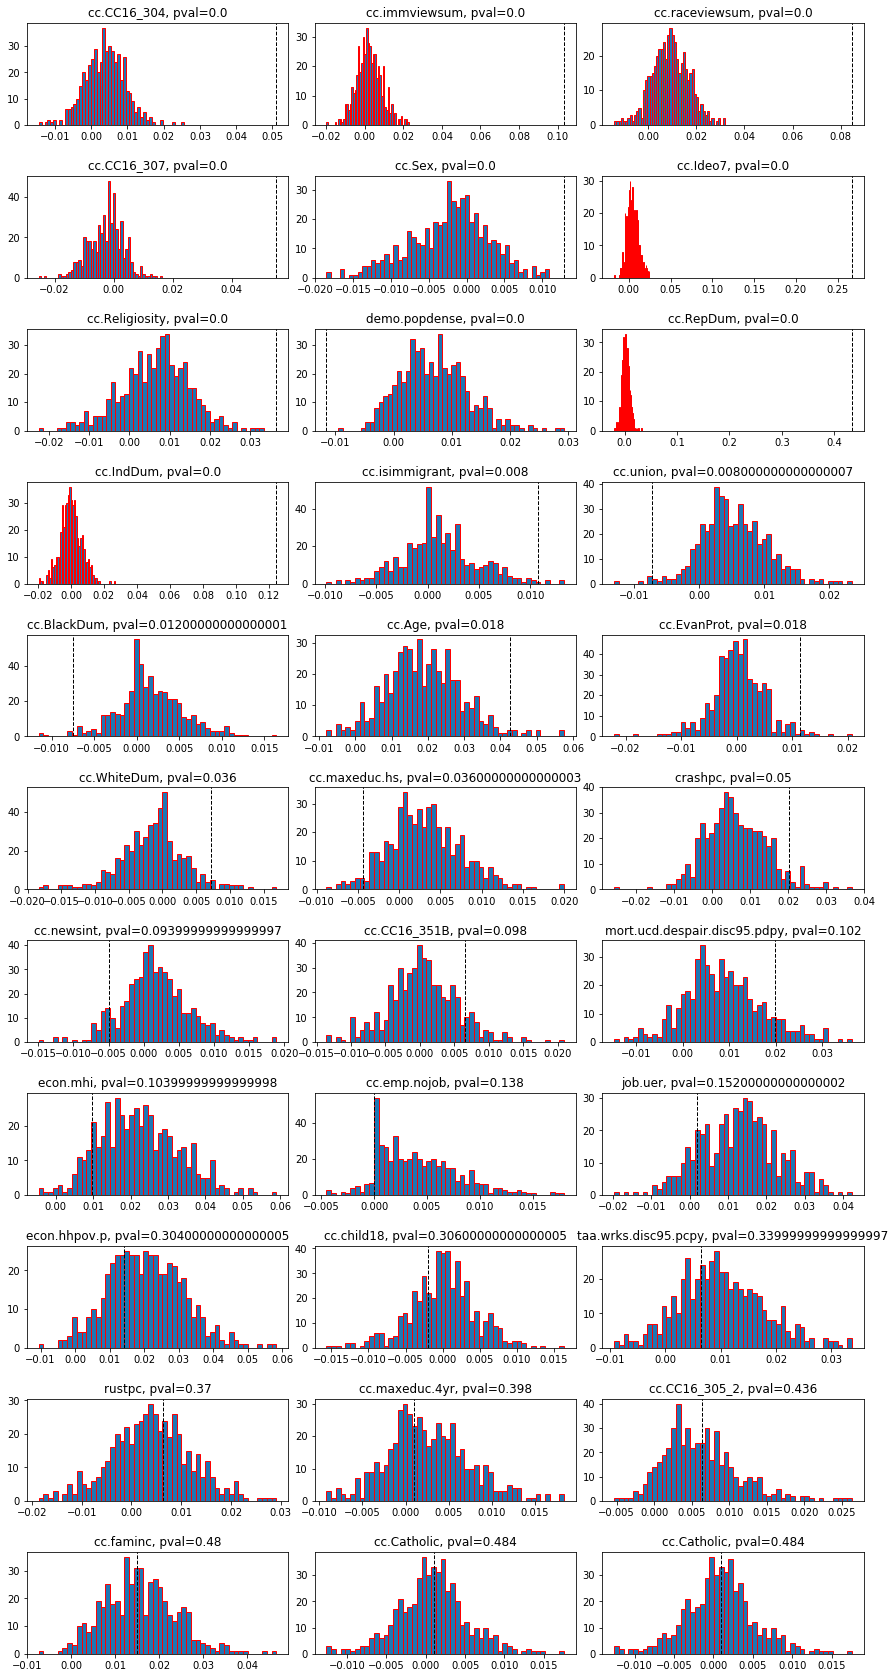

In [185]:
print ("--- line is not-permuted calc, others are permuted calcs")
draw_histograms(res, columns, 11,3)